# Setup

In [1]:
import numpy as np
from gurobipy import *
from mrsort_data_generator import *
from SAT_interval_data_generator import *
from simplified.linear_program import *
from simplified.sat_program import sat_resolve, check_answer
from simplified.sat_weighted_program import sat_weighted_resolve, check_weighted_answer
from simplified.sat_interval_program import sat_interval_resolve, check_interval_answer
import matplotlib.pyplot as plt
import time
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Définition d'une distance

In [2]:
def distance(references, predictions):
    if predictions == [['-']]:
        return '-'
    sum_distances = 0
    n_distances = 0
    print(predictions)
    for i in range (len(predictions)):
        s = 0
        for j in range (len(predictions[i])):
            s += (predictions[i][j] - references[i][j]) ** 2
        sum_distances += np.sqrt(s)
        n_distances += 1
    return sum_distances / n_distances

# Modèle simple

## Chargement des données

In [3]:
ground_truth, grades, admission = load_mrsort_as_txt("data/data.txt")
ground_truth_noise, grades_noise, admission_noise = load_mrsort_as_txt("data/data_noise.txt")

if len(admission) != len(admission_noise) or len(ground_truth['boundary'][0]) != len(ground_truth_noise['boundary'][0]) or len(ground_truth['boundary']) != len(ground_truth_noise['boundary']):
    print("Les jeux de données n'ont pas les mêmes caractéristiques")

n_instances = len(admission)
n_criteria = len(ground_truth['boundary'][0])
n_class = len(ground_truth['boundary']) + 1

print(f"Nombre d'instances : {n_instances}\nNombre de critères : {n_criteria}\nNombre de classes : {n_class}")

Nombre d'instances : 1000
Nombre de critères : 6
Nombre de classes : 3


## Chargement des résultats

### Solveurs linéaires

In [4]:
models = {}
models_noise = {}

linear_start = time.time()
linear_w, linear_l, linear_z, linear_f = best_result_maxmin(grades, admission, n_criteria, n_class)
linear_end = time.time()
models['Linéaire'] = {
    'weights': linear_w,
    'lambda': linear_l,
    'frontier': linear_f,
    'precision': check_linear_answer(grades, admission, linear_f, linear_l, linear_w, n_criteria),
    'time': linear_end-linear_start
}

linear_start_noise = time.time()
linear_noise_w, linear_noise_l, linear_noise_z, linear_noise_f = best_result_maxmin(grades_noise, admission_noise, n_criteria, n_class)
linear_end_noise = time.time()
models_noise['Linéaire bruité'] = {
    'weights': linear_noise_w,
    'lambda': linear_noise_l,
    'frontier': linear_noise_f,
    'precision': check_linear_answer(grades_noise, admission_noise, linear_noise_f, linear_noise_l, linear_noise_w, n_criteria),
    'time': linear_end_noise-linear_start_noise
}

Set parameter Username
Academic license - for non-commercial use only - expires 2022-12-09


In [5]:
linear_ms_start = time.time()
linear_ms_w, linear_ms_l, linear_ms_z, linear_ms_f = best_result_maxsum(grades, admission, n_criteria, n_class)
linear_ms_end = time.time()
models['Linéaire MaxSum'] = {
    'weights': linear_ms_w,
    'lambda': linear_ms_l,
    'frontier': linear_ms_f,
    'precision': check_linear_answer(grades, admission, linear_ms_f, linear_ms_l, linear_ms_w, n_criteria),
    'time': linear_ms_end-linear_ms_start
}

linear_ms_start_noise = time.time()
linear_ms_noise_w, linear_ms_noise_l, linear_ms_noise_z, linear_ms_noise_f = best_result_maxsum(grades_noise, admission_noise, n_criteria, n_class)
linear_ms_end_noise = time.time()
models_noise['Linéaire MaxSum bruité'] = {
    'weights': linear_ms_noise_w,
    'lambda': linear_ms_noise_l,
    'frontier': linear_ms_noise_f,
    'precision': check_linear_answer(grades_noise, admission_noise, linear_ms_noise_f, linear_ms_noise_l, linear_ms_noise_w, n_criteria),
    'time': linear_ms_end_noise-linear_ms_start_noise
}

### Solveur SAT

In [6]:
sat_start = time.time()
sat_satisfiable, sat_list, sat_grades, sat_valid_subsets, sat_f = sat_resolve(grades, admission, n_instances, n_criteria, n_class)
sat_end = time.time()

if sat_satisfiable:
    models['SAT simple'] = {
        'weights': ['-'],
        'lambda': '-',
        'frontier': sat_f,
        'precision': check_answer(sat_grades, sat_valid_subsets, admission),
        'time': sat_end-sat_start
    }
else:
    print("L'ensemble d'apprentissage ne peut pas être appris avec un modèle NCS")

sat_noise_start = time.time()
sat_noise_satisfiable, sat_noise_list, sat_noise_grades, sat_noise_valid_subsets, sat_noise_f = sat_resolve(grades_noise, admission_noise, n_instances, n_criteria, n_class)
sat_noise_end = time.time()

if sat_noise_satisfiable:
    models_noise['SAT simple bruité'] = {
        'weights': ['-'],
        'lambda': '-',
        'frontier': sat_noise_f,
        'precision': check_answer(sat_noise_grades, sat_noise_valid_subsets, admission_noise),
        'time': sat_noise_end-sat_noise_start
    }
else:
    print("L'ensemble d'apprentissage bruité ne peut pas être appris avec un modèle NCS")

L'ensemble d'apprentissage bruité ne peut pas être appris avec un modèle NCS


### Solveur MaxSAT

In [7]:
sat_weighted_start = time.time()
sat_weighted_nb_insatisfiable, sat_weighted_list, sat_weighted_grades, sat_weighted_valid_subsets, sat_weighted_f = sat_weighted_resolve(grades, admission, n_instances, n_criteria, n_class)
sat_weighted_end = time.time()

models['SAT weighted'] = {
    'weights': ['-'],
    'lambda': '-',
    'frontier': sat_weighted_f,
    'precision': check_weighted_answer(sat_weighted_grades, sat_weighted_valid_subsets, admission),
    'time': sat_weighted_end-sat_weighted_start
}

sat_weighted_noise_start = time.time()
sat_weighted_noise_nb_insatisfiable, sat_weighted_noise_list, sat_weighted_noise_grades, sat_weighted_noise_valid_subsets, sat_weighted_noise_f = sat_weighted_resolve(grades_noise, admission_noise, n_instances, n_criteria, n_class)
sat_weighted_noise_end = time.time()

models_noise['SAT weighted bruité'] = {
    'weights': ['-'],
    'lambda': '-',
    'frontier': sat_weighted_noise_f,
    'precision': check_weighted_answer(sat_weighted_noise_grades, sat_weighted_noise_valid_subsets, admission_noise),
    'time': sat_weighted_noise_end-sat_weighted_noise_start
}

### Résultats

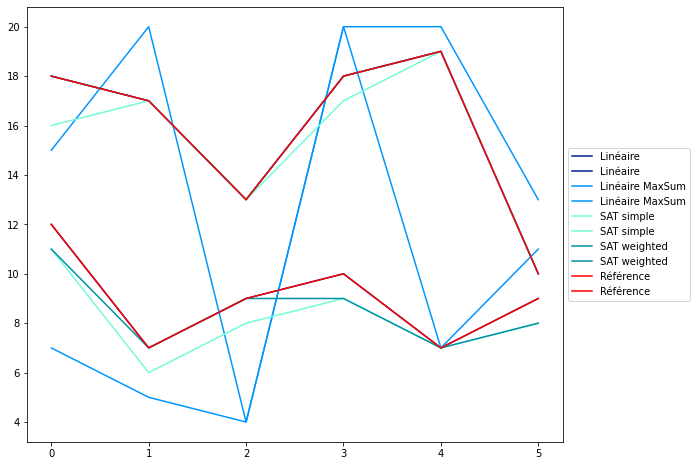

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['#011993', '#0096FF', '#73FCD6', "#0091A5", 'r']

i = 0
for model_name, model in models.items():
    for boundary in model['frontier']:
        ax.plot(boundary, colors[i], label=model_name)
    i += 1

for boundary in ground_truth['boundary']:
    ax.plot(boundary, colors[i], label='Référence')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')

plt.show()

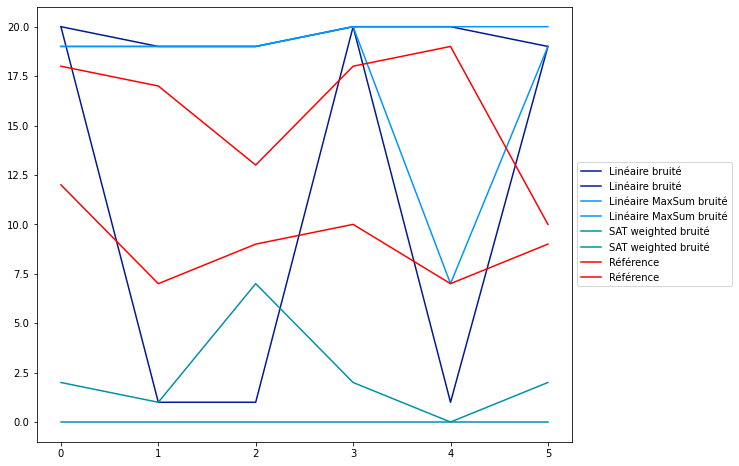

<Figure size 1440x1440 with 0 Axes>

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = plt.figure(figsize=(20, 20))
colors = ['#011993', '#0096FF', "#0091A5", 'r']

i = 0
for model_name, model in models_noise.items():
    for boundary in model['frontier']:
        ax.plot(boundary, colors[i], label=model_name)
    i += 1

for boundary in ground_truth['boundary']:
    ax.plot(boundary, colors[i], label='Référence')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')

plt.show()

## Comparaison

In [10]:
results = {'Distance frontière': [], 'Distance lambda': [], 'Distance poids': [], "Taux de restauration": [], "Temps d'exécution": []}
index = []
for model_name, model in models.items():
    results['Distance frontière'].append(distance(ground_truth['boundary'], model['frontier']))
    results['Distance lambda'].append(distance([[ground_truth['lambda']]], [[model['lambda']]]))
    results['Distance poids'].append(distance([ground_truth['weights']], [model['weights']]))
    results['Taux de restauration'].append(str(round((1-model['precision'])*100))+"%")
    results["Temps d'exécution"].append(model['time'])
    index.append(model_name)
for model_name, model in models_noise.items():
    results['Distance frontière'].append(distance(ground_truth['boundary'], model['frontier']))
    results['Distance lambda'].append(distance([[ground_truth['lambda']]], [[model['lambda']]]))
    results['Distance poids'].append(distance([ground_truth['weights']], [model['weights']]))
    results['Taux de restauration'].append(str(round((1-model['precision'])*100))+"%")
    results["Temps d'exécution"].append(model['time'])
    index.append(model_name)
results = pd.DataFrame(data=results, index=index)

results

[array([12.,  7.,  9., 10.,  7.,  9.]), array([18., 17., 13., 18., 19., 10.])]
[[0.5624999999999999]]
[array([0.125, 0.25 , 0.125, 0.125, 0.25 , 0.125])]
[array([ 7.,  5.,  4., 20.,  7., 11.]), array([15., 20.,  4., 20., 20., 13.])]
[[1.0]]
[array([0., 0., 0., 0., 1., 0.])]
[[11, 6, 8, 9, 7, 8], [16, 17, 13, 17, 19, 10]]
[[11, 7, 9, 9, 7, 8], [18, 17, 13, 18, 19, 10]]
[array([20.,  1.,  1., 20.,  1., 19.]), array([20., 19., 19., 20., 20., 19.])]
[[0.0]]
[array([1., 0., 0., 0., 0., 0.])]
[array([19., 19., 19., 20.,  7., 19.]), array([19., 19., 19., 20., 20., 20.])]
[[1.0]]
[array([0., 0., 0., 0., 1., 0.])]
[[0, 0, 0, 0, 0, 0], [2, 1, 7, 2, 0, 2]]


Distance frontière Distance lambda Distance poids  \
Linéaire                          0.000000          0.0125      0.0483188   
Linéaire MaxSum                  11.599975            0.45       0.798475   
SAT simple                        2.236068               -              -   
SAT weighted                      0.866025               -              -   
Linéaire bruité                  15.700877            0.55       0.968278   
Linéaire MaxSum bruité           17.143325            0.45       0.798475   
SAT weighted bruité              28.753520               -              -   

                       Taux de restauration  Temps d'exécution  
Linéaire                               100%          22.948544  
Linéaire MaxSum                         74%           5.580560  
SAT simple                             100%           1.222320  
SAT weighted                           100%           2.217071  
Linéaire bruité                          2%          14.508523  
Linéaire MaxSum bruité                  74%           5.133193  
SAT weighted bruité                     42%           2.467614

# Intervalle

## Chargement des modèles

In [11]:
ground_truth_interval, grades_interval, admission_interval = load_mrsort_interval_as_txt("data/data_itvl.txt")
ground_truth_interval_noise, grades_interval_noise, admission_interval_noise = load_mrsort_interval_as_txt("data/data_itvl_noise.txt")

if len(admission_interval) != len(admission_interval_noise) or len(ground_truth_interval['boundary'][0]) != len(ground_truth_interval_noise['boundary'][0]) or len(ground_truth_interval['boundary']) != len(ground_truth_interval_noise['boundary']):
    print("Les jeux de données n'ont pas les mêmes caractéristiques")

n_instances_interval = len(admission_interval)
n_criteria_interval = len(ground_truth_interval['boundary'][0])
n_class_interval = len(ground_truth_interval['boundary']) + 1

print(f"Nombre d'instances : {n_instances_interval}\nNombre de critères : {n_criteria_interval}\nNombre de classes : {n_class_interval}")

Nombre d'instances : 200
Nombre de critères : 5
Nombre de classes : 3


## Chargement des résultats

In [12]:
models_interval = {}

sat_interval_start = time.time()
sat_interval_satisfiable, sat_interval_list, sat_interval_grades, sat_interval_valid_subsets, sat_interval_f = sat_interval_resolve(grades_interval, admission_interval, n_instances_interval, n_criteria_interval, n_class_interval)
sat_interval_end = time.time()

if sat_interval_satisfiable:
    models_interval['SAT intervalle'] = {
        'weights': ['-'],
        'lambda': '-',
        'frontier': sat_interval_f,
        'precision': check_interval_answer(sat_interval_grades, sat_interval_valid_subsets, admission_interval),
        'time': sat_interval_end-sat_interval_start
    }
else:
    print("L'ensemble d'apprentissage ne peut pas être appris avec un modèle NCS")

sat_interval_noise_start = time.time()
sat_interval_noise_satisfiable, sat_interval_noise_list, sat_interval_noise_grades, sat_interval_noise_valid_subsets, sat_interval_noise_f = sat_interval_resolve(grades_interval_noise, admission_interval_noise, n_instances_interval, n_criteria_interval, n_class_interval)
sat_interval_noise_end = time.time()

if sat_interval_noise_satisfiable:
    models_interval['SAT intervalle bruité'] = {
        'weights': ['-'],
        'lambda': '-',
        'frontier': sat_interval_noise_f,
        'precision': check_interval_answer(sat_interval_noise_grades, sat_interval_noise_valid_subsets, admission_interval_noise),
        'time': sat_interval_noise_end-sat_interval_noise_start
    }
else:
    print("L'ensemble d'apprentissage bruité ne peut pas être appris avec un modèle NCS")

L'ensemble d'apprentissage bruité ne peut pas être appris avec un modèle NCS


{'weights': ['-'], 'lambda': '-', 'frontier': [[[37, 77], [23, 67], [49, 95], [55, 93], [8, 41]], [[43, 72], [42, 57], [63, 73], [59, 80], [8, 22]]], 'precision': 0.0, 'time': 32.02874302864075}


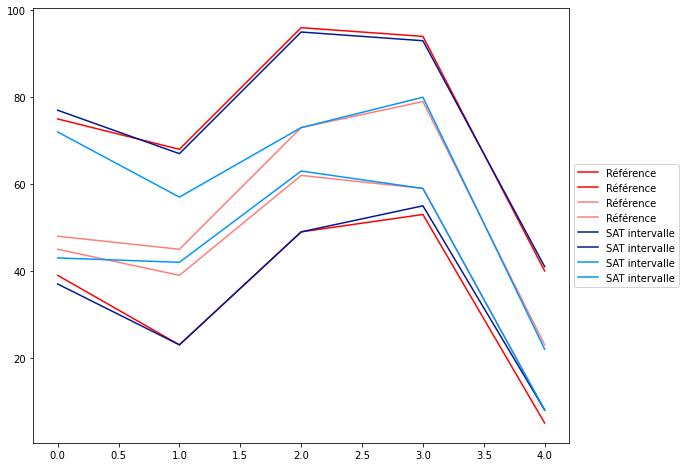

In [13]:
print(models_interval['SAT intervalle'])
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['r', '#FF7E79', '#011993', '#0096FF']
i = 0
for boundary in ground_truth_interval['boundary']:
    for j in range (len(boundary[0])):
        ax.plot([b[j] for b in boundary], colors[i], label='Référence')
    i += 1
for model_name, model in models_interval.items():
    for boundary in model['frontier']:
        for j in range (len(boundary[0])):
            ax.plot([b[j] for b in boundary], colors[i], label=model_name)
        i += 1

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')

plt.show()

## Comparaison

In [14]:
results = {'Distance frontière': [], 'Distance lambda': [], 'Distance poids': [], "Taux de restauration": [], "Temps d'exécution": []}
index = []
for model_name, model in models_interval.items():
    results['Distance frontière'].append(distance(ground_truth_interval['boundary'][0], model['frontier'][0]))
    results['Distance lambda'].append(distance([[ground_truth_interval['lambda']]], [[model['lambda']]]))
    results['Distance poids'].append(distance([ground_truth_interval['weights']], [model['weights']]))
    results['Taux de restauration'].append(str(round((1-model['precision'])*100))+"%")
    results["Temps d'exécution"].append(model['time'])
    index.append(model_name)
results = pd.DataFrame(data=results, index=index)

results

[[37, 77], [23, 67], [49, 95], [55, 93], [8, 41]]


Distance frontière Distance lambda Distance poids  \
SAT intervalle            2.045355               -              -   

               Taux de restauration  Temps d'exécution  
SAT intervalle                 100%          32.028743

# Temps d'exécution

In [15]:
def get_grades(n_criteria, n_instances, n_class, noise=0):

    ground_truth = generate_ground_truth(n_criteria, n_class)
    grades, admission = generate_train_mrsort(ground_truth, n_instances, noise)
    
    return grades, admission

In [16]:
time_results = {'linear_maxmin': [], 'linear_maxsum': [], 'sat': [], 'sat_weighted': []}
index = []
n_criteria = 3

for nb_instances in range(100, 1100, 100):
    grades, admission = get_grades(n_criteria, nb_instances, n_class)
    linear_start = time.time()
    linear_w, linear_l, linear_z, linear_f = best_result_maxmin(grades, admission, n_criteria, n_class)
    linear_end = time.time()
    time_results['linear_maxmin'].append(linear_end-linear_start)
    linear_ms_start = time.time()
    linear_ms_w, linear_ms_l, linear_ms_z, linear_ms_f = best_result_maxsum(grades, admission, n_criteria, n_class)
    linear_ms_end = time.time()
    time_results['linear_maxsum'].append(linear_ms_end-linear_ms_start)
    sat_start = time.time()
    sat_satisfiable, sat_list, sat_grades, sat_valid_subsets, sat_f = sat_resolve(grades, admission, nb_instances, n_criteria, n_class)
    sat_end = time.time()
    time_results['sat'].append(sat_end-sat_start)
    grades_noise, admission_noise = get_grades(n_criteria, nb_instances, n_class, noise=2/nb_instances)
    sat_weighted_start = time.time()
    sat_weighted_noise_nb_insatisfiable, sat_weighted_noise_list, sat_weighted_noise_grades, sat_weighted_noise_valid_subsets, sat_weighted_noise_f = sat_weighted_resolve(grades_noise, admission_noise, nb_instances, n_criteria, n_class)
    sat_weighted_end = time.time()
    time_results['sat_weighted'].append(sat_weighted_end-sat_weighted_start)    
    index.append(nb_instances)

>>> GROUND TRUTH GENERATED
weights : [0.6222222222222222, 0.2, 0.17777777777777778]
lambda : 0.8344175462670498
boundary : [[5, 10, 3], [17, 11, 15]]
>>> TRAINING DATA GENERATED
>>> GROUND TRUTH GENERATED
weights : [0.21022727272727273, 0.30113636363636365, 0.48863636363636365]
lambda : 0.25584320824888196
boundary : [[5, 13, 10], [7, 15, 14]]
>>> TRAINING DATA GENERATED
>>> GROUND TRUTH GENERATED
weights : [0.2553191489361702, 0.44148936170212766, 0.30319148936170215]
lambda : 0.7123556194248468
boundary : [[16, 9, 4], [17, 20, 7]]
>>> TRAINING DATA GENERATED
>>> GROUND TRUTH GENERATED
weights : [0.36318407960199006, 0.417910447761194, 0.21890547263681592]
lambda : 0.8696425816512448
boundary : [[4, 9, 5], [12, 15, 16]]
>>> TRAINING DATA GENERATED
>>> GROUND TRUTH GENERATED
weights : [0.2981366459627329, 0.5652173913043478, 0.13664596273291926]
lambda : 0.2523673531813587
boundary : [[12, 14, 8], [15, 20, 9]]
>>> TRAINING DATA GENERATED
>>> GROUND TRUTH GENERATED
weights : [0.74074074

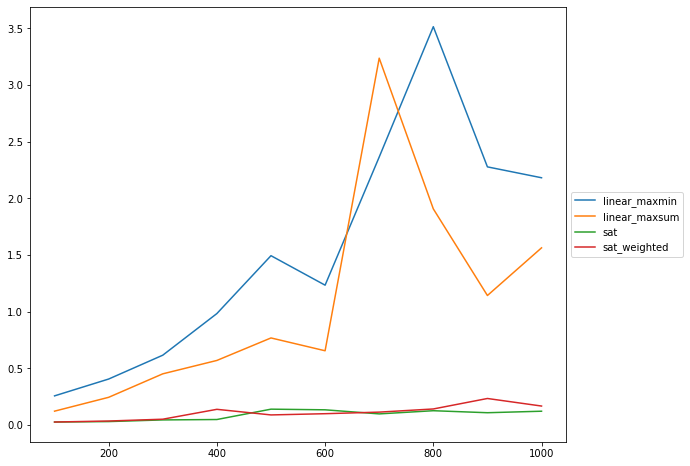

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))

i = 0
for model_name, time_result in time_results.items():
    ax.plot(index, time_result, label=model_name)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')

plt.show()

In [18]:
time_results_criteria = {'linear_maxmin': [], 'linear_maxsum': [], 'sat': [], 'sat_weighted': []}
index_criteria = []
n_instances = 500

for nb_criteria in range(1, 7):
    grades, admission = get_grades(nb_criteria, n_instances, n_class)
    linear_start = time.time()
    linear_w, linear_l, linear_z, linear_f = best_result_maxmin(grades, admission, nb_criteria, n_class)
    linear_end = time.time()
    time_results_criteria['linear_maxmin'].append(linear_end-linear_start)
    linear_ms_start = time.time()
    linear_ms_w, linear_ms_l, linear_ms_z, linear_ms_f = best_result_maxsum(grades, admission, nb_criteria, n_class)
    linear_ms_end = time.time()
    time_results_criteria['linear_maxsum'].append(linear_ms_end-linear_ms_start)
    sat_start = time.time()
    sat_satisfiable, sat_list, sat_grades, sat_valid_subsets, sat_f = sat_resolve(grades, admission, n_instances, nb_criteria, n_class)
    sat_end = time.time()
    time_results_criteria['sat'].append(sat_end-sat_start)
    grades_noise, admission_noise = get_grades(nb_criteria, n_instances, n_class, noise=0.01)
    sat_weighted_start = time.time()
    sat_weighted_noise_nb_insatisfiable, sat_weighted_noise_list, sat_weighted_noise_grades, sat_weighted_noise_valid_subsets, sat_weighted_noise_f = sat_weighted_resolve(grades_noise, admission_noise, n_instances, nb_criteria, n_class)
    sat_weighted_end = time.time()
    time_results_criteria['sat_weighted'].append(sat_weighted_end-sat_weighted_start)    
    index_criteria.append(nb_criteria)

>>> GROUND TRUTH GENERATED
weights : [1.0]
lambda : 0.11602612779015153
boundary : [[12], [19]]
>>> TRAINING DATA GENERATED
>>> GROUND TRUTH GENERATED
weights : [1.0]
lambda : 0.4128339567800198
boundary : [[5], [7]]
>>> TRAINING DATA GENERATED
>>> GROUND TRUTH GENERATED
weights : [0.36942675159235666, 0.6305732484076433]
lambda : 0.37284464320262967
boundary : [[1, 2], [7, 9]]
>>> TRAINING DATA GENERATED
>>> GROUND TRUTH GENERATED
weights : [0.4675324675324675, 0.5324675324675324]
lambda : 0.46518480348994606
boundary : [[15, 1], [17, 15]]
>>> TRAINING DATA GENERATED
>>> GROUND TRUTH GENERATED
weights : [0.25, 0.25510204081632654, 0.49489795918367346]
lambda : 0.341029203616503
boundary : [[11, 5, 1], [12, 19, 9]]
>>> TRAINING DATA GENERATED
>>> GROUND TRUTH GENERATED
weights : [0.6556291390728477, 0.15894039735099338, 0.18543046357615894]
lambda : 0.8005063765011856
boundary : [[0, 1, 12], [18, 16, 15]]
>>> TRAINING DATA GENERATED
>>> GROUND TRUTH GENERATED
weights : [0.2415094339622

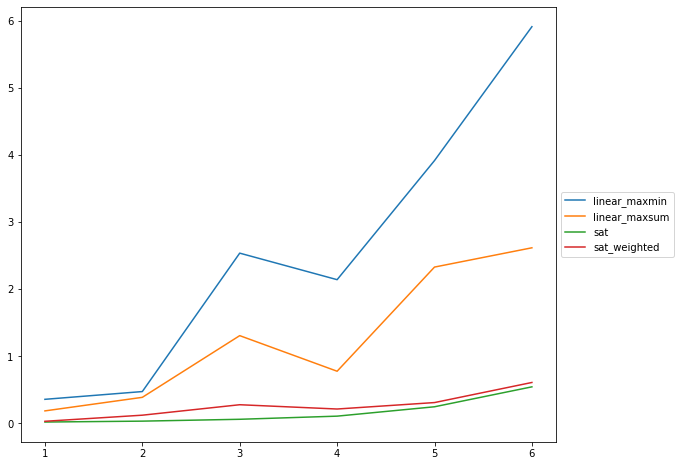

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

i = 0
for model_name, time_result_criteria in time_results_criteria.items():
    ax.plot(index_criteria, time_result_criteria, label=model_name)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')

plt.show()